# Overview
Here, we predict whether a human is going to make a mistake in a given chess position. More precisely, we estimate both the expected centi-pawn loss and the expected blunder (CP loss > 200) probability given a player's Elo rating. We base this analysis on a dataset of 23,000 games that have been fully evaluated by a computer (1.9 Million evaluations).

This model can be used in a variety of ways:
  1. If we hold the Elo constant, these predictions are, intuitively, a good measure a position's sharpness, since players will be more likely to make mistakes in sharp positions. 
  2. We can understand how players of certain strength play in certain positions. For instance, some positions are handled almost perfectly by elite players, but beginners will likely blunder in them.
  
At a high level, our model supplements the computer evaluation of a position. A widely held belief among chess players is that a computer evaluation is less important when a position is sharp. To quantify this belief, we need a definition of sharpness, and our predictive score is tailored to this purpose.

The predictions (CP loss or blunder probability) are obtained from a supervised model that simply predicts the same outcome in a large sample of games.

**We have turned this model into an interactive [web app](https://chessinsights.org/analysis/)! So you can just go there and see what you think of the results**. You can also check out [the database](https://chessinsights.org) and even add your own games for evaluation!

## Comparison to previous work

Existing research (Guid and Bratko, 2006, G-B going forward) has defined sharpness using the change in evaluation as an engine's depth increases. This measure has the advantage that it is very easy to obtain when running computer evaluations. We find that our measure is only weakly correlated with the G-B measure (note: These scores are no longer available because of database updates).

## Next steps

These predictions can be used to create "human evaluations" of a given chess position. Specifically, one can ask the following: Given a certain chess position, what is the best move I should play to win the game? The best move (highest win probability) might not have the highest computer evaluation, and a crucial factor is that humans make mistakes when the position is sharp.

## Notes on the model

Currently, our model tries to minimize the required prior knowledge about chess. The input is simply a position's FEN, and this is split into a large vector and fed into a two-stage dense neural network.

# Validation overview: Candidates 2018
Here, we present an overview of the validation and analyses with the data. You can also think of this as "fun statistics we can create with our model".

We use games from the Candidates 2018 to evalute our results.  We can use this tournament to investigate whether our results are reasonable. First, we present how sharply each participant played.

We find that Levon Aronian played the sharpest chess, and Wesley So played least sharply. The one surprising result is that one would expect Vladimir Kramnik to show up more highly in the list, because his play was widely deemed to be extremely dynamic.

In [61]:
player_stats

,Predicted Sharpness,CP Loss
last_name_white,,
Aronian,19.42,26.84
Caruana,20.62,15.01
Ding,20.37,16.05
Grischuk,19.47,16.90
Karjakin,20.35,19.17
Kramnik,20.79,15.23
Mamedyarov,19.11,14.52
So,17.62,11.77


## Game Statistics
We now investigate how sharply each game was played. Overall, these results feel sensible. A likely reason is that, by averaging predictions over a number of moves, this statistic eliminates noise in the prediction.

The comparison between the "sharpest" and "least sharp" games is stark: The sharpest games consistently involve huge complexity and attacking chess. The least sharp games usually involve quick piece exchanges and simplification into a drawn endgame.

## Sharpest Games

In [62]:
game_stats.head(10)

,game_id,last_name_white,last_name_black,Predicted Sharpness,CP Loss
0,3449,Caruana,Mamedyarov,31.74,16.02
1,3456,Kramnik,Caruana,28.84,25.62
2,3476,Karjakin,Kramnik,28.67,24.66
3,3446,Ding,Caruana,27.41,13.17
4,3442,Karjakin,Mamedyarov,22.33,24.54
5,3454,Grischuk,Ding,22.13,33.92
6,3487,Karjakin,Caruana,22.00,13.88
7,3445,Grischuk,So,21.89,22.41
8,3477,Kramnik,Aronian,21.84,23.47
9,3457,Aronian,Grischuk,21.83,29.31


## Least sharp games

In [63]:
game_stats.tail(10)

,game_id,last_name_white,last_name_black,Predicted Sharpness,CP Loss
46,3491,So,Karjakin,17.03,7.00
47,3471,Mamedyarov,Karjakin,17.03,11.93
48,3479,Ding,So,17.02,8.00
49,3447,Mamedyarov,Aronian,16.97,9.83
50,3458,Caruana,Karjakin,16.96,11.03
51,3455,Mamedyarov,So,16.94,8.97
52,3484,So,Mamedyarov,16.93,12.51
53,3480,Grischuk,Karjakin,16.83,7.11
54,3462,Ding,Karjakin,16.72,13.22
55,3467,Grischuk,Mamedyarov,16.58,8.38


## Example positions
This is the most intuitive validation: We simply show positions that are deemed either sharp or non-sharp, and chess players can get a feeling for whether these predictions are sensible.

In [64]:
df = df_cand.query('10 <= move_number <= 30').sort_values('pred_sharpness', ascending=False)

### Sharp

In [82]:
df_sharp = df.head(100)
df_sharp.pred_sharpness.mean()

32.265873

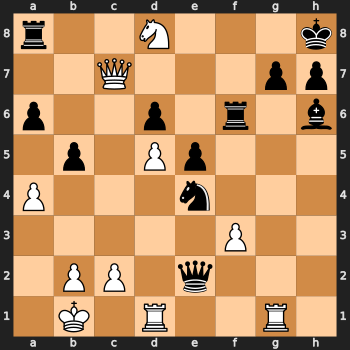

In [83]:
fen_to_svg(df_sharp.fen.iloc[0])

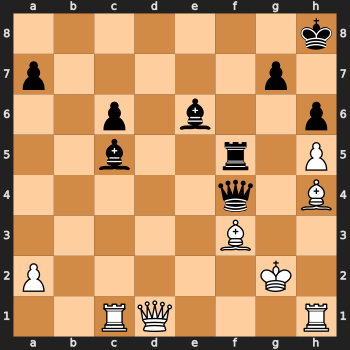

In [84]:
fen_to_svg(df_sharp.fen.iloc[1])

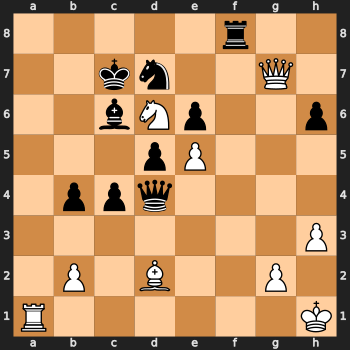

In [85]:
fen_to_svg(df_sharp.fen.iloc[2])

### Not sharp

In [86]:
df_nonsharp = df.tail(100)
df_nonsharp.pred_sharpness.mean()

16.959846

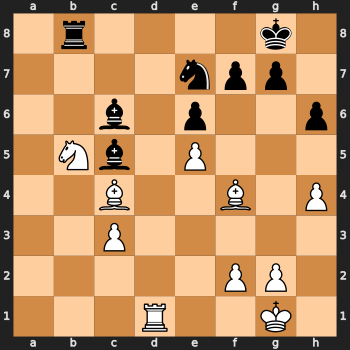

In [87]:
fen_to_svg(df_nonsharp.fen.iloc[0])

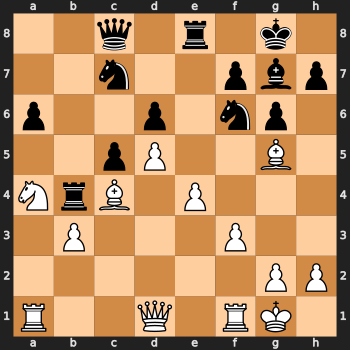

In [88]:
fen_to_svg(df_nonsharp.fen.iloc[1])

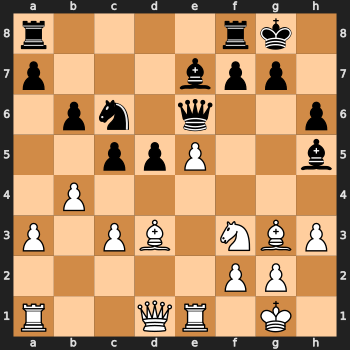

In [89]:
fen_to_svg(df_nonsharp.fen.iloc[2])

# Analysis

In [12]:
# Ignoring warnings here.
import warnings
warnings.filterwarnings('ignore')

In [13]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
import pandas.io.sql as sqlio
from sklearn.ensemble import RandomForestRegressor

import statsmodels
import statsmodels.formula.api as smf

import chess
import chess.svg
from IPython.display import SVG

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers
import chess
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LeakyReLU

In [14]:
import queries
import functions as f
import imp
imp.reload(queries); imp.reload(f);

In [15]:
pd.set_option('precision', 2)
pd.set_option('display.width', 200)
pd.set_option('max_colwidth',90)

use_dev = False
connstring = f.CONNSTRING_DEV if use_dev else f.CONNSTRING_PROD

conn = psycopg2.connect(connstring)
params = {
  'move_number_start': 20
, 'move_number_end': 40
}

In [81]:
def fen_to_svg(fen):
    fen_small = fen.replace('fen ', '')
    board = chess.Board(fen_small)
    return chess.svg.board(board, size=350)  

# Loading the raw data

In [16]:
df_games = sqlio.read_sql_query(queries.q_games, conn).rename(columns={'id': 'game_id'})
df_db = sqlio.read_sql_query(queries.q_db, conn).rename(columns={'id': 'database_id'})
df_players = sqlio.read_sql_query(queries.q_players, conn).rename(columns={'id': 'player_id'})
df_tournaments = sqlio.read_sql_query(queries.q_tournaments, conn).rename(columns={'id': 'tournament'})
df_attributes = sqlio.read_sql_query("SELECT * from game_attribute", conn)

In [17]:
df_eval_raw = sqlio.read_sql_query("SELECT * from move_eval", conn)
len(df_eval_raw)

2278583

In [19]:
df = df_games.merge(df_attributes
                    .query('attribute=="BlackElo"')[['game_id', 'value']]
                   .rename(columns={'value': 'elo_black'}))
df = df.merge(df_attributes
                    .query('attribute=="WhiteElo"')[['game_id', 'value']]
                    .rename(columns={'value': 'elo_white'}))
df = df.merge(df_players[['player_id', 'last_name']].rename(
    columns={'player_id': 'player_white_id', 'last_name': 'last_name_white'}), on='player_white_id')
df = df.merge(df_players[['player_id', 'last_name']].rename(
    columns={'player_id': 'player_black_id', 'last_name': 'last_name_black'}), on='player_black_id')
df = df.merge(df_tournaments[['tournament', 'name']].rename(
    columns={'name': 'tournament_name'}), on='tournament')
df = df.merge(df_db[['database_id', 'name']].rename(
    columns={'name': 'database_name'}), on='database_id')
df = df[df.elo_white!=""]
df = df[df.elo_black!=""]
for var in ['elo_white', 'elo_black']:
    df = df[pd.to_numeric(df[var], errors='coerce').notnull()].copy()
    df[var] = df[var].astype(int)
    

In [20]:
cols_add = ['tournament', 'tournament_name', 'database_name', 'game_id', 
            'elo_white', 'elo_black', 
            'last_name_white', 'last_name_black',
            'player_white_id', 'player_black_id']
df_eval = df_eval_raw.merge(df[cols_add])

In [21]:
df_eval.database_name.value_counts()

kingbase_random                       1198196
Rejkjavik Open 2018                     74934
Candidates 2011-2018                    19663
World Championships 1886-2014           19280
Wijk An Zee (Tata Steel) 2012-2018      16912
Supertournaments 2017                   14358
Name: database_name, dtype: int64

In [22]:
summary = {
    'Number of evaluations': len(df_eval),
    'Number of games': df_eval.game_id.nunique(),
    'Number of players': df_eval.player_white_id.nunique()
}
summary

{'Number of evaluations': 1343343,
 'Number of games': 16238,
 'Number of players': 7797}

In [23]:
tournament_cand = df_tournaments.query('name=="FIDE Candidates 2018"').tournament.iloc[0]
tournament_cand

132

In [24]:
tournaments_eval = [tournament_cand]

# Cleaning the data

In [25]:
MAX_CP_LOSS = 200

cploss_raw = (-1 + 2 * df_eval.is_white) * (df_eval.eval_best - df_eval['eval'])

df_eval['cploss'] = f.top_and_bottom(cploss_raw, 0, MAX_CP_LOSS)
df_eval['is_blunder'] = 1 * cploss_raw >= 200
df_eval['eval_lagged'] = df_eval.groupby('game_id').eval_best.shift(1)
df_eval['avg_cp_loss'] = df_eval.groupby('game_id').cploss.transform(np.mean)
df_eval = df_eval.query('is_white')

df_eval['fen_simple'] = [s[1] for s in df_eval.fen.str.split(' ')]

df_eval['is_excluded'] = df_eval.tournament.isin(tournaments_eval)

In [26]:
df_eval[['is_blunder', 'cploss']].mean()

is_blunder     0.02
cploss        20.97
dtype: float64

In [27]:
def fen_clean(fen):
    cleaned = fen
    for number in range(1, 9):
        cleaned = cleaned.replace(str(number), 'E' * number)
    cleaned = cleaned.replace('/', '')
    assert len(cleaned) == 64
    return cleaned

In [28]:
all_pieces = 'pPnNbBrRqQkK'
def fen_to_pieces(fen):
    pieces = fen_clean(fen)
    return [piece == p for piece in pieces for p in all_pieces]

In [29]:
castling_values = 'kKqQ'
def castling_rights(rights):
    return [v in rights for v in castling_values]

In [30]:
def fen_covars(fen):
    s = fen.split(' ')
    s_pos = s[1]
    s_castle = s[3]
    covars_pos = fen_to_pieces(s_pos)
    covars_castle = castling_rights(s_castle)
    is_white = s[2] == 'w'
    return covars_pos + covars_castle #+ [is_white]

In [31]:
ELO_SCALE = 3000

In [32]:
def fen_features(row):
    #return [row.elo_white]
    covars_fen = fen_covars(row.fen)
    return covars_fen + [row.elo_white / ELO_SCALE]

In [33]:
ix = df_eval.cploss.notnull()
df_reg = df_eval[ix] #

df_reg = df_reg.sample(len(df_reg)) #.sample(len(df_reg))
df_reg = df_reg[df_reg.cploss.notnull()].copy()
df_reg['val'] = (np.random.random(len(df_reg)) > 0.8) | (df_reg.is_excluded)

df_train = df_reg.query('not val').copy()
df_val = df_reg.query('val').copy()

X_train = np.array([fen_features(row[1]) for row in df_train.iterrows()]).astype(float)
X_val = np.array([fen_features(row[1]) for row in df_val.iterrows()]).astype(float)

In [34]:
outcomes = ['cploss', 'is_blunder']
stds = df_train[outcomes].std()
Y_train = np.array(df_train[outcomes] / stds)
Y_val = np.array(df_val[outcomes] / stds)
n_covars = X_train.shape[1]

In [35]:
stds

cploss        35.81
is_blunder     0.12
dtype: float64

In [36]:
X_train.shape, Y_train.shape, Y_val.shape

((536670, 773), (536670, 2), (137935, 2))

In [37]:
import itertools

In [38]:
def dict_product(dicts):
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

In [39]:
def get_model(x_train, y_train, x_val, y_val, params):
    model = keras.Sequential([
        layers.Dense(params['num_activations'], activation='relu', input_shape=[n_covars]), 
        keras.layers.Dropout(params['dropout']),
        layers.Dense(params['num_activations_2'], activation=params['activation']),
        keras.layers.Dense(Y_train.shape[1])
    ])
    optimizer = tf.keras.optimizers.Adamax(lr=params['lr'], beta_1=0.9, beta_2=0.999)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    model.build()
    out = model.fit(x_train, y_train, epochs=params['epochs'], 
              batch_size=params['batch_size'], 
              validation_data=(x_val, y_val))
    return out, model

In [40]:
p = {
    'activation': ['relu'],
    'num_activations': [20, 50, 100, 200],
    'num_activations_2': [5, 20],
    'dropout': [0.2, 0.5],
    'batch_size': [100, 1000],
    'epochs': [10, 50],
    'lr': [0.1, 0.001]
}
ps = list(dict_product(p))

In [41]:
NUM_MODELS = 2

ps = list(np.random.choice(ps, size=NUM_MODELS, replace=False))
len(ps)

2

In [42]:
for p in ps:
    out, model = get_model(X_train, Y_train, X_val, Y_val, p)
    p['val_loss'] = out.history['val_loss'][0] * 100
    p['loss'] = out.history['loss'][0] * 100

Epoch 1/50
5367/5367 [==============================] - 7s 1ms/step - loss: 0.9969 - mae: 0.4375 - mse: 0.9969 - val_loss: 0.9449 - val_mae: 0.4472 - val_mse: 0.9449
Epoch 2/50
5367/5367 [==============================] - 6s 1ms/step - loss: 0.9567 - mae: 0.4419 - mse: 0.9567 - val_loss: 0.9370 - val_mae: 0.4260 - val_mse: 0.9370
Epoch 3/50
5367/5367 [==============================] - 7s 1ms/step - loss: 0.9629 - mae: 0.4412 - mse: 0.9629 - val_loss: 0.9307 - val_mae: 0.4299 - val_mse: 0.9307
Epoch 4/50
5367/5367 [==============================] - 6s 1ms/step - loss: 0.9301 - mae: 0.4316 - mse: 0.9301 - val_loss: 0.9272 - val_mae: 0.4195 - val_mse: 0.9272
Epoch 5/50
5367/5367 [==============================] - 7s 1ms/step - loss: 0.9242 - mae: 0.4303 - mse: 0.9242 - val_loss: 0.9255 - val_mae: 0.4235 - val_mse: 0.9255
Epoch 6/50
5367/5367 [==============================] - 6s 1ms/step - loss: 0.9061 - mae: 0.4242 - mse: 0.9061 - val_loss: 0.9252 - val_mae: 0.4282 - val_mse: 0.9252
Epoc

5367/5367 [==============================] - 7s 1ms/step - loss: 0.6589 - mae: 0.3615 - mse: 0.6589 - val_loss: 0.9523 - val_mae: 0.4062 - val_mse: 0.9523
Epoch 1/10
5367/5367 [==============================] - 5s 948us/step - loss: 1.0019 - mae: 0.4238 - mse: 1.0019 - val_loss: 0.9503 - val_mae: 0.4426 - val_mse: 0.9503
Epoch 2/10
5367/5367 [==============================] - 5s 891us/step - loss: 0.9726 - mae: 0.4381 - mse: 0.9726 - val_loss: 0.9427 - val_mae: 0.4360 - val_mse: 0.9427
Epoch 3/10
5367/5367 [==============================] - 5s 881us/step - loss: 0.9604 - mae: 0.4355 - mse: 0.9604 - val_loss: 0.9388 - val_mae: 0.4399 - val_mse: 0.9388
Epoch 4/10
5367/5367 [==============================] - 5s 890us/step - loss: 0.9566 - mae: 0.4353 - mse: 0.9566 - val_loss: 0.9365 - val_mae: 0.4402 - val_mse: 0.9365
Epoch 5/10
5367/5367 [==============================] - 5s 911us/step - loss: 0.9483 - mae: 0.4339 - mse: 0.9483 - val_loss: 0.9347 - val_mae: 0.4242 - val_mse: 0.9347
Epoch

In [48]:
num_estimated = len([p.get('val_loss', None) for p in ps if p.get('val_loss', None) is not None])
num_estimated

2

In [49]:
df = pd.DataFrame(ps)
df = df[df.val_loss.notnull()].sort_values('val_loss')
df.head(20)

,activation,num_activations,num_activations_2,dropout,batch_size,epochs,lr,val_loss,loss
0,relu,100,5,0.2,100,50,1.00e-03,94.49,98.04
1,relu,20,5,0.2,100,10,1.00e-03,95.03,98.62


In [50]:
optimizer = tf.keras.optimizers.Adamax(lr=0.03, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
model.build()

In [51]:
hist = model.fit(X_train, Y_train, epochs=50, batch_size=1000, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/50
537/537 [==============================] - 3s 4ms/step - loss: 0.8351 - mae: 0.4034 - mse: 0.8351 - val_loss: 0.9579 - val_mae: 0.4111 - val_mse: 0.9579
Epoch 2/50
537/537 [==============================] - 2s 3ms/step - loss: 0.8234 - mae: 0.3999 - mse: 0.8234 - val_loss: 0.9689 - val_mae: 0.4255 - val_mse: 0.9689
Epoch 3/50
537/537 [==============================] - 2s 3ms/step - loss: 0.8214 - mae: 0.4000 - mse: 0.8214 - val_loss: 0.9613 - val_mae: 0.4092 - val_mse: 0.9613
Epoch 4/50
537/537 [==============================] - 2s 3ms/step - loss: 0.8136 - mae: 0.3980 - mse: 0.8136 - val_loss: 0.9659 - val_mae: 0.4174 - val_mse: 0.9659
Epoch 5/50
537/537 [==============================] - 2s 3ms/step - loss: 0.8163 - mae: 0.3985 - mse: 0.8163 - val_loss: 0.9722 - val_mae: 0.3878 - val_mse: 0.9722
Epoch 6/50
537/537 [==============================] - 2s 3ms/step - loss: 0.8106 - mae: 0.3963 - mse: 0.8106 - val_loss: 0.9699 - val_mae: 0.4074 - val_mse: 0.9699
Epoch 7/50
537/5

In [52]:
model.save('sharpness.h5')

# Validation

## What is the predictive power of the score?
Here, we look at the correlation between the score and the actual loss. We find that it stands at around 0.28. By holding the player's ELO constant, we obtain a measure of a position's sharpness, we find that this is still correlated decently with the outcome variables (0.24).

There is no clear sense of how good this performance is. In future work, we plan to investigate how this prediction compares to human estimates of sharpness.

In [53]:
ELO_ELITE = 2800
df_val['pred'] = model.predict(X_val)[:, 0] * stds['cploss']
X_val_2 = X_val.copy()
X_val_2[:, -1] = ELO_ELITE / ELO_SCALE
df_val['pred_sharpness'] = model.predict(X_val_2)[:, 0] * stds['cploss']
df_val.query('is_white')[['cploss', 'elo_white', 'pred', 'pred_sharpness']].corr() * 100

,cploss,elo_white,pred,pred_sharpness
cploss,100.00,-8.43,20.27,16.56
elo_white,-8.43,100.00,-10.84,-0.28
pred,20.27,-10.84,100.00,91.53
pred_sharpness,16.56,-0.28,91.53,100.00


In [54]:
df_val[['cploss', 'pred_sharpness']].mean()

cploss            20.83
pred_sharpness    18.84
dtype: float64

# Evaluating the results: 2018 Candidates

In [55]:
df_cand = df_val[df_val.tournament == tournament_cand]

## Sharpness by player

In [56]:
player_stats = (
    df_cand
    .query('is_white')
    .groupby('last_name_white')['pred_sharpness', 'cploss']
    .mean()
    .rename(columns={'pred_sharpness': 'Predicted Sharpness', 'cploss': 'CP Loss'}))

player_stats

,Predicted Sharpness,CP Loss
last_name_white,,
Aronian,19.42,26.84
Caruana,20.62,15.01
Ding,20.37,16.05
Grischuk,19.47,16.90
Karjakin,20.35,19.17
Kramnik,20.79,15.23
Mamedyarov,19.11,14.52
So,17.62,11.77


## Game statistics

In [57]:
group_vars = ['game_id', 'last_name_white', 'last_name_black']
game_stats = (
    df_cand.groupby(group_vars)[['pred_sharpness', 'cploss']]
    .mean()
    .sort_values('pred_sharpness', ascending=False)
    .reset_index()
    .rename(columns={'pred_sharpness': 'Predicted Sharpness', 'cploss': 'CP Loss'})
)

### Sharpest games

In [58]:
game_stats.head(10)

,game_id,last_name_white,last_name_black,Predicted Sharpness,CP Loss
0,3449,Caruana,Mamedyarov,31.74,16.02
1,3456,Kramnik,Caruana,28.84,25.62
2,3476,Karjakin,Kramnik,28.67,24.66
3,3446,Ding,Caruana,27.41,13.17
4,3442,Karjakin,Mamedyarov,22.33,24.54
5,3454,Grischuk,Ding,22.13,33.92
6,3487,Karjakin,Caruana,22.00,13.88
7,3445,Grischuk,So,21.89,22.41
8,3477,Kramnik,Aronian,21.84,23.47
9,3457,Aronian,Grischuk,21.83,29.31


### Least sharp games

In [59]:
game_stats.tail(10)

,game_id,last_name_white,last_name_black,Predicted Sharpness,CP Loss
46,3491,So,Karjakin,17.03,7.00
47,3471,Mamedyarov,Karjakin,17.03,11.93
48,3479,Ding,So,17.02,8.00
49,3447,Mamedyarov,Aronian,16.97,9.83
50,3458,Caruana,Karjakin,16.96,11.03
51,3455,Mamedyarov,So,16.94,8.97
52,3484,So,Mamedyarov,16.93,12.51
53,3480,Grischuk,Karjakin,16.83,7.11
54,3462,Ding,Karjakin,16.72,13.22
55,3467,Grischuk,Mamedyarov,16.58,8.38


In [60]:
(df_val.groupby(group_vars)[['pred_sharpness', 'cploss']].mean()
    .sort_values('pred_sharpness', ascending=False)
    .reset_index())

,game_id,last_name_white,last_name_black,pred_sharpness,cploss
0,16322,Sandler,Handoko,115.81,106.25
1,15470,Santos,Paunovic,73.68,6.60
2,19372,Lara Granero,Perez Garcia,63.39,28.25
3,19240,Chumpitaz,Oliva Castaneda,62.63,48.78
4,16346,Tunik,Turov,58.12,73.44
...,...,...,...,...,...
16116,20583,Zpevak,Velicka,15.44,7.00
16117,3943,Hestnes,Briem,15.44,6.00
16118,19734,Miladinovic,Nestorovic,15.44,3.00
16119,23228,Juric,Radulovic,15.44,34.00
